# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

##### Notebook settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

##### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight

import keras
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, Flatten, ZeroPadding2D
from keras import layers
from tensorflow.keras.applications import ResNet50V2, EfficientNetB4
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam

import os, shutil, random, cv2
from shutil import copyfile
from distutils.dir_util import copy_tree
from tqdm import tqdm

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [3]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:06, 125MB/s]


##### Define constants

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SIZE = [256, 256] # dataset image size is 299x299
EPOCHS = 20

## Data


### Create dataset

In [5]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [6]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [7]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [8]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [9]:
# create train-val-test split
x_train, x_val, y_train, y_val = train_test_split(files, labels, test_size=2*SPLIT, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=random_state)

In [10]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [11]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set:   ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 3810, 'COVID-19': 2518}
val set:    {'normal': 804, 'COVID-19': 552}
test set:   {'normal': 810, 'COVID-19': 546}


###### Create tensors

In [12]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [13]:
def get_img(x, y):
    file_path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [14]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

In [15]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_ds).numpy()
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 6328, Val: 1356, Test: 1356


### Prepare for training

###### Define preprocessing

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])

###### Define data augmentation

In [17]:
# implemented as keras layers below but kept for quick overview
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=(0.85, 1.15), # randomly zoom image 
        brightness_range=(0.9, 1.1), # randomly shift brightness
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='constant',   # constant filling of points outside boundaries of input
        cval=0.,)   # fill with zeros, see fill_mode

In [18]:
class RandomBrightness(layers.Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [20]:
def prepare_training(ds, shuffle=False, repeat=False, augment=False, cache=True, shuffle_buffer_size=1000):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # repeat training set forever
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)

    # batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # fetches batches in the background while training the model
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [21]:
train_batched = prepare_training(train_ds, shuffle=True, repeat=True, augment=True, cache='cache')
val_batched = prepare_training(val_ds)
test_batched = prepare_training(test_ds)

### Visualization

###### Distribution of labels in the sets

In [22]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

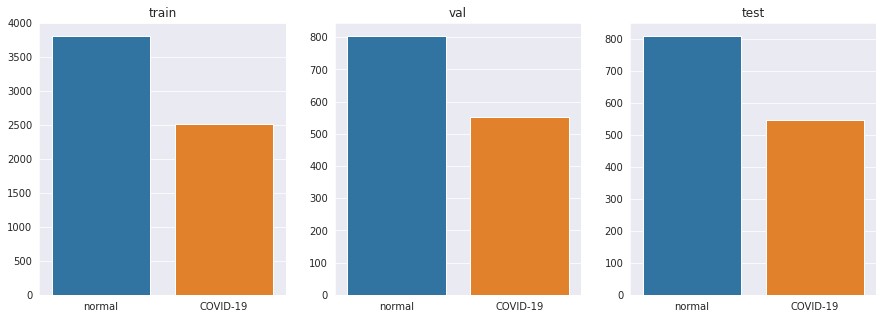

In [23]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [24]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [25]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


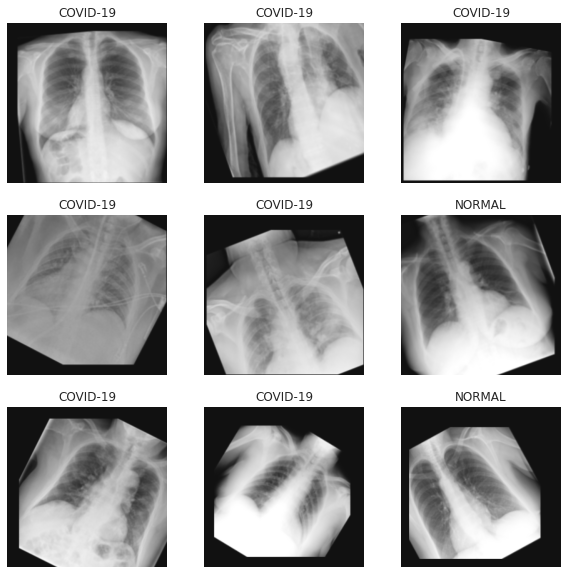

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [27]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())
print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.26


### Learning rate decay

In [28]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

### Early stopping


In [29]:
# checkpoint = ModelCheckpoint("x-covid.h5", monitor=monitor='val_loss', save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## ResNet50V2
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [30]:
def resnet50_builder():
    # load pretrained ResNet50V2 (ImageNet) without output
    resnet = ResNet50V2(include_top = False,
                       weights = 'imagenet',
                       input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),)
    
    # make resnet layers trainable
    resnet.trainable = True
    
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        # add pretrained resnet layer to model
        resnet,
        # add last pooling layer
        GlobalAveragePooling2D(name='AvgPool'),
        # add dropout (inspired by inception-resnet-v2)
        Dropout(0.2, name='Dropout'),
        # add classification layer for normal/COVID-19
        Dense(units=1, activation='sigmoid', name='Output'),
    ], name='ResNet50')
    
    return model

In [31]:
resnet50 = resnet50_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50.compile(
    # very low learning rate to adapt pretrained weights to new data without
    # overfitting because of small dataset
    optimizer=Adam(lr=1e-5), # default: 1e-3
    loss='binary_crossentropy',
    metrics=METRICS
)

94674944/94668760 [==============================] - 3s 0us/step


In [32]:
resnet50.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [33]:
history_resnet = resnet50.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
197/197 [==============================] - 75s 263ms/step - loss: 0.5562 - accuracy: 0.7066 - precision: 0.6230 - recall: 0.7023 - val_loss: 0.4074 - val_accuracy: 0.8207 - val_precision: 0.9072 - val_recall: 0.6241
Epoch 2/20
197/197 [==============================] - 47s 237ms/step - loss: 0.2780 - accuracy: 0.8941 - precision: 0.8550 - recall: 0.8815 - val_loss: 0.3007 - val_accuracy: 0.9129 - val_precision: 0.8659 - val_recall: 0.9307
Epoch 3/20
197/197 [==============================] - 47s 237ms/step - loss: 0.1781 - accuracy: 0.9324 - precision: 0.9108 - recall: 0.9222 - val_loss: 0.1855 - val_accuracy: 0.9278 - val_precision: 0.9501 - val_recall: 0.8686
Epoch 4/20
197/197 [==============================] - 46s 235ms/step - loss: 0.1456 - accuracy: 0.9472 - precision: 0.9284 - recall: 0.9417 - val_loss: 0.1678 - val_accuracy: 0.9360 - val_precision: 0.8799 - val_recall: 0.9763
Epoch 5/20
197/197 [==============================] - 46s 235ms/step - loss: 0.1208 - accura

### Evaluation

###### Visualize performance

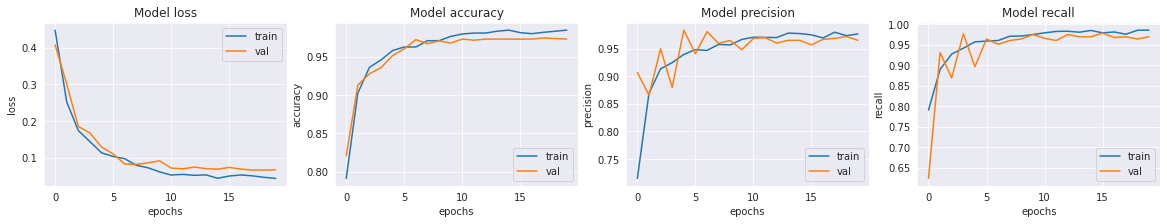

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet.history[met])
    ax[i].plot(history_resnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [35]:
loss, acc, prec, rec = resnet50.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 3s 71ms/step - loss: 0.0512 - accuracy: 0.9867 - precision: 0.9818 - recall: 0.9853
Loss of the model is -  0.05124344676733017
Accuracy of the model is -  98.67256879806519 %
Precision of the model is -  0.9817517995834351
Recall of the model is -  0.9853479862213135


## EfficientNet-B4
[Paper](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=EfficientNet%3A+Rethinking+Model+Scaling+for+Convolutional+Neural+Networks&btnG=)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [36]:
DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

def effnetb4_builder():
    # load pretrained EfficientNetB4 (ImageNet) without output
    effnet = EfficientNetB4(include_top = False,
                       weights = 'imagenet',
                       input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),)
    
    # make resnet layers trainable
    effnet.trainable = True
    
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        # add pretrained effnet layer to model
        effnet,
        # add last pooling layer
        GlobalAveragePooling2D(name='AvgPool'),
        # add dropout
        Dropout(0.2, name='Dropout'),
        # add classification layer for normal/COVID-19
        Dense(units=1, activation='sigmoid', kernel_initializer=DENSE_KERNEL_INITIALIZER, name='Output'),
    ], name='EfficientNetB4')
    
    return model

In [37]:
effnetb4 = effnetb4_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

effnetb4.compile(
    # very low learning rate to adapt pretrained weights to new data without
    # overfitting because of small dataset
    optimizer=Adam(lr=1e-5), # default: 1e-3
    loss='binary_crossentropy',
    metrics=METRICS
)

71688192/71686520 [==============================] - 1s 0us/step


In [38]:
effnetb4.summary()

Model: "EfficientNetB4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 8, 8, 1792)        17673823  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 1792)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 1793      
Total params: 17,675,616
Trainable params: 17,550,409
Non-trainable params: 125,207
_________________________________________________________________


### Training

In [39]:
history_effnetb4 = effnetb4.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
197/197 [==============================] - 145s 656ms/step - loss: 1.7525 - accuracy: 0.5744 - precision: 0.4793 - recall: 0.6568 - val_loss: 1.3162 - val_accuracy: 0.4137 - val_precision: 0.4099 - val_recall: 0.9964
Epoch 2/20
197/197 [==============================] - 126s 641ms/step - loss: 0.9285 - accuracy: 0.7546 - precision: 0.6719 - recall: 0.7590 - val_loss: 1.1841 - val_accuracy: 0.5067 - val_precision: 0.4452 - val_recall: 0.8522
Epoch 3/20
197/197 [==============================] - 127s 643ms/step - loss: 0.7199 - accuracy: 0.7923 - precision: 0.7169 - recall: 0.7949 - val_loss: 0.9012 - val_accuracy: 0.6629 - val_precision: 0.5623 - val_recall: 0.7828
Epoch 4/20
197/197 [==============================] - 126s 640ms/step - loss: 0.6970 - accuracy: 0.8114 - precision: 0.7489 - recall: 0.7975 - val_loss: 0.6718 - val_accuracy: 0.7135 - val_precision: 0.6308 - val_recall: 0.7172
Epoch 5/20
197/197 [==============================] - 126s 642ms/step - loss: 0.5588 - a

### Evaluation

###### Visualize performance

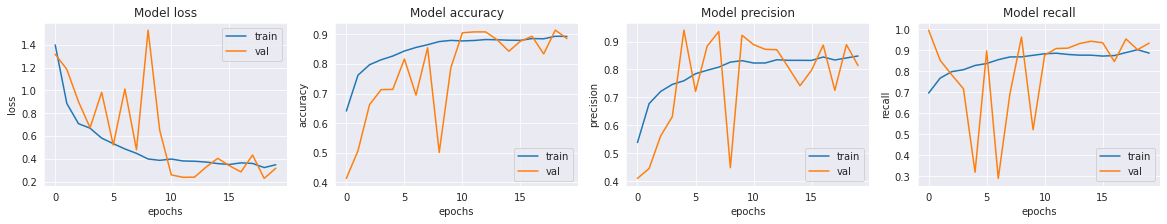

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_effnetb4.history[met])
    ax[i].plot(history_effnetb4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [41]:
loss, acc, prec, rec = effnetb4.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 5s 114ms/step - loss: 0.2820 - accuracy: 0.9019 - precision: 0.8252 - recall: 0.9597
Loss of the model is -  0.28201618790626526
Accuracy of the model is -  90.19173979759216 %
Precision of the model is -  0.8251968622207642
Recall of the model is -  0.9597069621086121


## DarkNet (Based on DarkCovidNet)
[Paper](https://scholar.google.com/scholar_lookup?title=Automated%20detection%20of%20COVID-19%20cases%20using%20deep%20neural%20networks%20with%20X-ray%20images&publication_year=2020&author=T.%20Ozturk)
[Github](https://github.com/ieee8023/covid-chestxray-dataset)

### Model definition

DarkNet block definition

In [42]:
def darknet_block(filters, kernel_size=3, strides=1):
    block = Sequential([
        ZeroPadding2D(padding=(1, 1)),
        Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='valid', use_bias=False),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
    ])
    return block

def triple_conv(prev, filters):
    return Sequential([
        darknet_block(filters),
        darknet_block(prev, kernel_size=1),  
        darknet_block(filters)
    ])

def max_pool():
    return MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')

In [43]:
def darknet_builder():
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        darknet_block(8),
        max_pool(),
        darknet_block(16),
        max_pool(),
        triple_conv(16, 32),
        max_pool(),
        triple_conv(32, 64),
        max_pool(),
        triple_conv(64, 128),
        max_pool(),
        triple_conv(128, 256),
        darknet_block(128, kernel_size=1),
        darknet_block(256),
        darknet_block(3),
        Flatten(),
        Dense(units=1, activation='sigmoid')
    ], name='DarkNet')
    
    return model

In [44]:
darknet = darknet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

darknet.compile(
    optimizer=Adam(lr=1e-3), # default: 1e-3
    loss='binary_crossentropy',
    metrics=METRICS
)

In [45]:
darknet.summary()
darknet.layers[4].layers[1].summary()

Model: "DarkNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 256, 256, 8)       248       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 128, 128, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 66, 66, 32)        10048     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 35, 35, 64)        3955

### Training

In [46]:
history_darknet = darknet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
197/197 [==============================] - 39s 182ms/step - loss: 0.6201 - accuracy: 0.6704 - precision: 0.5753 - recall: 0.7422 - val_loss: 0.7644 - val_accuracy: 0.4077 - val_precision: 0.4077 - val_recall: 1.0000
Epoch 2/20
197/197 [==============================] - 36s 181ms/step - loss: 0.4455 - accuracy: 0.7788 - precision: 0.6798 - recall: 0.8450 - val_loss: 3.2571 - val_accuracy: 0.5409 - val_precision: 0.4681 - val_recall: 0.9252
Epoch 3/20
197/197 [==============================] - 35s 181ms/step - loss: 0.3901 - accuracy: 0.8157 - precision: 0.7304 - recall: 0.8534 - val_loss: 0.6484 - val_accuracy: 0.7612 - val_precision: 0.6376 - val_recall: 0.9599
Epoch 4/20
197/197 [==============================] - 36s 181ms/step - loss: 0.3557 - accuracy: 0.8396 - precision: 0.7672 - recall: 0.8586 - val_loss: 0.4226 - val_accuracy: 0.8438 - val_precision: 0.9378 - val_recall: 0.6606
Epoch 5/20
197/197 [==============================] - 36s 182ms/step - loss: 0.3146 - accura

### Evaluation

###### Visualize performance

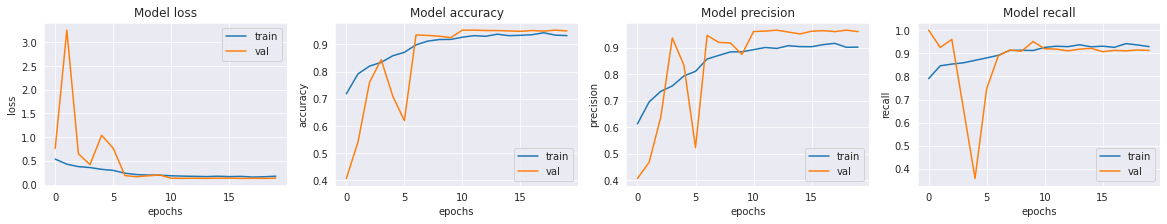

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_darknet.history[met])
    ax[i].plot(history_darknet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [48]:
loss, acc, prec, rec = darknet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 20ms/step - loss: 0.1493 - accuracy: 0.9484 - precision: 0.9779 - recall: 0.8919
Loss of the model is -  0.14933516085147858
Accuracy of the model is -  94.83776092529297 %
Precision of the model is -  0.977911651134491
Recall of the model is -  0.8919413685798645
